# Step 1

In [ ]:
# Step 1: Unzip the dataset
import zipfile
import os

# Updated path to the new zip file
zip_path = "selected_vggface2.zip"

# Updated path to extract the dataset
extract_path = "./selected_vggface2_dataset"

# Unzip only if the folder doesn't already exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset unzipped successfully!")
else:
    print("Dataset already unzipped.")


Dataset unzipped successfully!


# Step 2

In [ ]:
# Step 2: Load and preprocess the face dataset with a train-test split + augmentation

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Updated image size
IMG_SIZE = 128
BATCH_SIZE = 32
TEST_SPLIT = 0.2  # 20% for testing

# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Simpler transform for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Load dataset from updated root directory
full_dataset = datasets.ImageFolder(root="./selected_vggface2_dataset")

# Train-test split
total_size = len(full_dataset)
test_size = int(TEST_SPLIT * total_size)
train_size = total_size - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Assign transforms after splitting
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Sanity check
images, labels = next(iter(train_loader))
print(f"Sample batch shape from train_loader: {images.shape}")  # Should be [BATCH_SIZE, 3, 128, 128]


Total samples: 2541
Training samples: 2033
Test samples: 508
Sample batch shape from train_loader: torch.Size([32, 3, 128, 128])


# Step 3

Sample Images from Train and Test Sets:


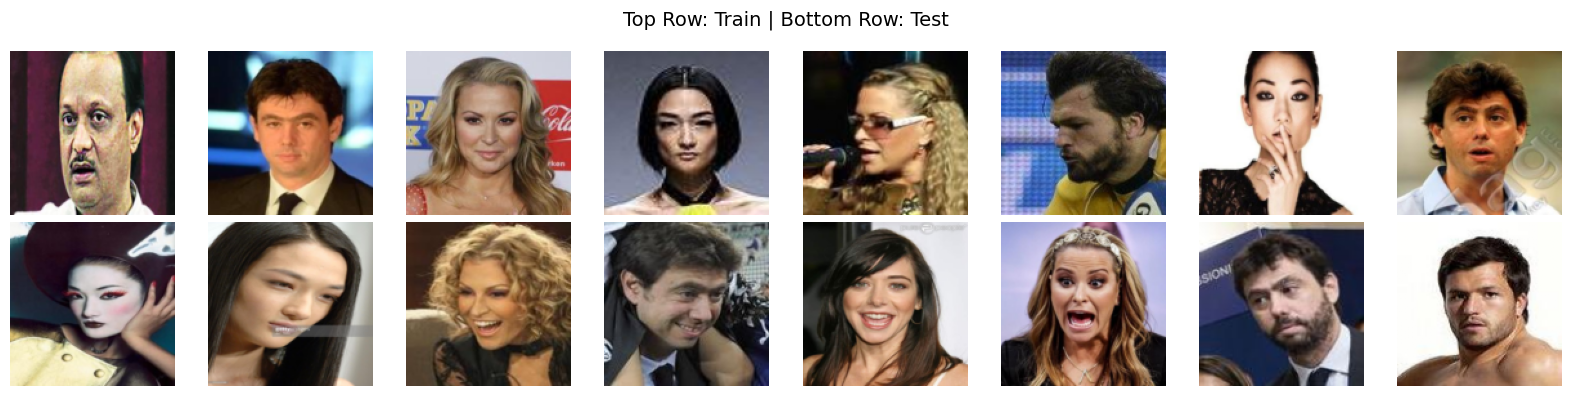

In [ ]:
# Step 3: Display a few clean face images from both train and test sets

import matplotlib.pyplot as plt
import numpy as np

# Helper function
def imshow_tensor(img_tensor):
    """Displays a single RGB image tensor (C, H, W)."""
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C x H x W → H x W x C
    img = np.clip(img, 0, 1)
    return img

# Get a sample batch from each loader
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Visualize
print("Sample Images from Train and Test Sets:")
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("Top Row: Train | Bottom Row: Test", fontsize=14)

for i in range(8):
    axs[0, i].imshow(imshow_tensor(train_images[i]))
    axs[0, i].axis('off')

    axs[1, i].imshow(imshow_tensor(test_images[i]))
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


# Step 4

Noise Visualization with Noise Factor = 0.4


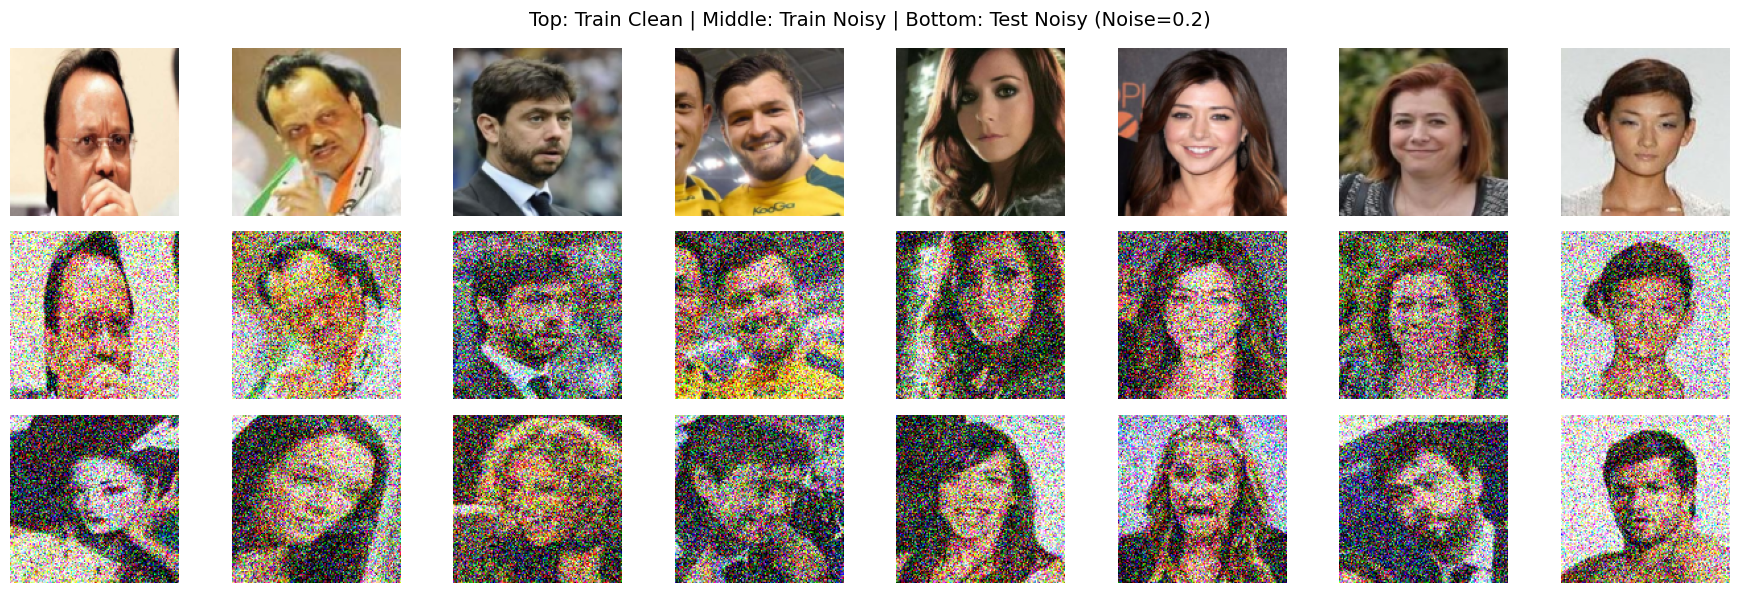

In [ ]:
import torch

# Noise factor as per your latest update
NOISE_FACTOR = 0.4

def add_noise(images, noise_factor=NOISE_FACTOR):
    """Adds Gaussian noise to RGB images."""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

# Sample batches from train and test
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Add Gaussian noise
train_noisy = add_noise(train_images, noise_factor=NOISE_FACTOR)
test_noisy = add_noise(test_images, noise_factor=NOISE_FACTOR)

# Visualize noise effect
print(f"Noise Visualization with Noise Factor = {NOISE_FACTOR}")

fig, axs = plt.subplots(3, 8, figsize=(18, 6))
fig.suptitle("Top: Train Clean | Middle: Train Noisy | Bottom: Test Noisy (Noise=0.2)", fontsize=14)

for i in range(8):
    axs[0, i].imshow(imshow_tensor(train_images[i]))
    axs[0, i].axis('off')

    axs[1, i].imshow(imshow_tensor(train_noisy[i]))
    axs[1, i].axis('off')

    axs[2, i].imshow(imshow_tensor(test_noisy[i]))
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()


# Step 5

In [ ]:
import torch
import torch.nn as nn

# Match the latest latent dimension and image resolution
LATENT_VECTOR_DIM = 256

class ImprovedCAE(nn.Module):
    def __init__(self, latent_vector_dim=LATENT_VECTOR_DIM, dropout_rate=0.3):
        super(ImprovedCAE, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 128x128 → 128x128
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),                           # → 64x64
            nn.Dropout2d(p=dropout_rate),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),                           # → 32x32
            nn.Dropout2d(p=dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),                           # → 16x16
            nn.Dropout2d(p=dropout_rate),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),                           # → 8x8
            nn.Dropout2d(p=dropout_rate),
        )

        # Latent layer
        self.flattened_size = 256 * 8 * 8
        self.fc_encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, latent_vector_dim)
        )

        self.fc_decode = nn.Sequential(
            nn.Linear(latent_vector_dim, self.flattened_size)
        )

        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32x32 → 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),    # 64x64 → 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        latent = self.fc_encode(x)
        x = self.fc_decode(latent)
        x = x.view(-1, 256, 8, 8)
        reconstructed = self.decoder(x)
        return reconstructed, latent

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCAE(latent_vector_dim=LATENT_VECTOR_DIM).to(device)

print("✅ Improved CAE model initialized for 128x128 input with latent dim 256:")
print(model)


✅ Improved CAE model initialized for 128x128 input with latent dim 256:
ImprovedCAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2,

# Step 6

In [ ]:
import wandb

sweep_config = {
    'method': 'random',
    'name': 'ImprovedCAE_128x128_Sweep_40epochs',
    'metric': {
        'name': 'best_val_mse',
        'goal': 'minimize'
    },
    'parameters': {
        'latent_vector_dim': {
            'values': [128, 256, 384]  # more aligned with your recent latent size
        },
        'learning_rate': {
            'values': [1e-3, 5e-4, 1e-4]
        },
        'noise_factor': {
            'values': [0.3, 0.4, 0.5]  # updated to focus on heavier noise
        },
        'batch_size': {
            'values': [16, 32]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4]  # slightly increased for stronger regularization
        },
        'epochs': {
            'value': 40
        },
        'model_type': {
            'value': 'ImprovedCAE'
        }
    }
}


# Step 7

In [ ]:
import wandb
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score
import copy
import os
import matplotlib.pyplot as plt

def train():
    # Initialize W&B
    run = wandb.init(project="GoTG_Assignment07_AE", entity="usf-guardians")
    wandb.run.name = f"ImprovedCAE_{run.id}"
    wandb.run.save()

    # Get sweep config
    config = wandb.config
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    noise_factor = config.noise_factor
    latent_dim = config.latent_vector_dim
    dropout_rate = config.dropout_rate
    epochs = config.epochs

    global train_loader, test_loader

    # Instantiate the model
    model = ImprovedCAE(latent_vector_dim=latent_dim, dropout_rate=dropout_rate).to(device)
    wandb.watch(model, log="all")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_model = None
    best_val_loss = float('inf')
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for clean_images, _ in train_loader:
            noisy_images = add_noise(clean_images, noise_factor)
            noisy = noisy_images.to(device)
            clean = clean_images.to(device)

            optimizer.zero_grad()
            outputs, _ = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * clean.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(clean.cpu())

        avg_loss = running_loss / len(train_loader.dataset)
        preds = torch.cat(all_preds).numpy().reshape(-1, 3 * 128 * 128)
        targets = torch.cat(all_targets).numpy().reshape(-1, 3 * 128 * 128)
        mae = mean_absolute_error(targets, preds)
        r2 = r2_score(targets, preds)

        wandb.log({
            "epoch": epoch + 1,
            "train_mse": avg_loss,
            "train_mae": mae,
            "train_r2": r2
        })

        epoch_losses.append(avg_loss)

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            best_model = copy.deepcopy(model.state_dict())

    # Log final/best metric
    wandb.log({"best_val_mse": best_val_loss})

    # Plot and log loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})

    # Visual Grid: Clean, Noisy, Reconstructed
    model.eval()
    sample_images, _ = next(iter(train_loader))
    sample_noisy = add_noise(sample_images, noise_factor).to(device)
    with torch.no_grad():
        sample_recon, _ = model(sample_noisy)

    img_grid = []
    for i in range(6):
        img_grid.extend([
            sample_images[i],
            sample_noisy[i].cpu(),
            sample_recon[i].cpu().detach()
        ])
    wandb.log({"comparison_grid": [wandb.Image(img) for img in img_grid]})

    # Save and log best model
    model_path = "best_cae_model.pth"
    torch.save(best_model, model_path)

    artifact = wandb.Artifact("best_cae_model", type="model")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Test evaluation
    all_test_preds, all_test_targets = [], []
    total_test_loss = 0.0

    with torch.no_grad():
        for clean_images, _ in test_loader:
            noisy_images = add_noise(clean_images, noise_factor).to(device)
            clean_images = clean_images.to(device)
            outputs, _ = model(noisy_images)
            loss = criterion(outputs, clean_images)

            total_test_loss += loss.item() * clean_images.size(0)
            all_test_preds.append(outputs.cpu())
            all_test_targets.append(clean_images.cpu())

    test_preds = torch.cat(all_test_preds).numpy().reshape(-1, 3 * 128 * 128)
    test_targets = torch.cat(all_test_targets).numpy().reshape(-1, 3 * 128 * 128)
    test_mse = total_test_loss / len(test_loader.dataset)
    test_mae = mean_absolute_error(test_targets, test_preds)
    test_r2 = r2_score(test_targets, test_preds)

    wandb.log({
        "test_mse": test_mse,
        "test_loss": test_mse,
        "test_mae": test_mae,
        "test_r2": test_r2
    })

    wandb.finish()


# Step 8

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: m9m16sev
Sweep URL: https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/sweeps/m9m16sev
Sweep created with ID: m9m16sev


wandb: Agent Starting Run: xkv06jqo with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 256
wandb: 	learning_rate: 0.001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.3
wandb: Currently logged in as: princepraveen (usf-guardians) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
best_val_mse,0.00924
epoch,40


wandb: Agent Starting Run: rq8j85hs with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.5


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
best_val_mse,0.01688
epoch,40


wandb: Agent Starting Run: m4l9s2di with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.3


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
best_val_mse,0.01769
epoch,40


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: puhhfeb6 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 384
wandb: 	learning_rate: 0.001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.5


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
best_val_mse,0.00964
epoch,40


wandb: Agent Starting Run: 3osvt0m6 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.0005
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.3


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
best_val_mse,0.01272
epoch,40


wandb: Agent Starting Run: ev520avf with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.0001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.4


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
best_val_mse,0.01835
epoch,40


wandb: Agent Starting Run: t6y0830x with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.5


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
best_val_mse,0.01274
epoch,40


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e3zpmo88 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.5


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
best_val_mse,0.01245
epoch,40


wandb: Agent Starting Run: 938a4r70 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.3


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
best_val_mse,0.0099
epoch,40


wandb: Agent Starting Run: 4b3re9wa with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	model_type: ImprovedCAE
wandb: 	noise_factor: 0.4


best_val_mse,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
test_mae,▁
test_mse,▁
test_r2,▁
train_mae,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
best_val_mse,0.01195
epoch,40


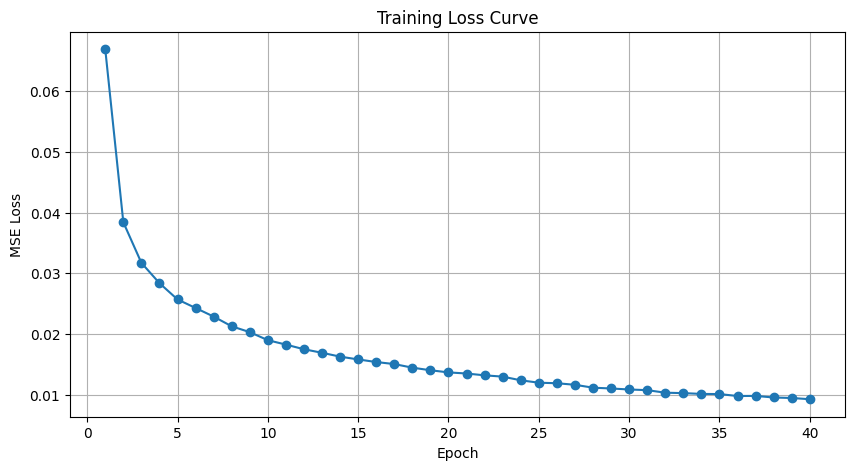

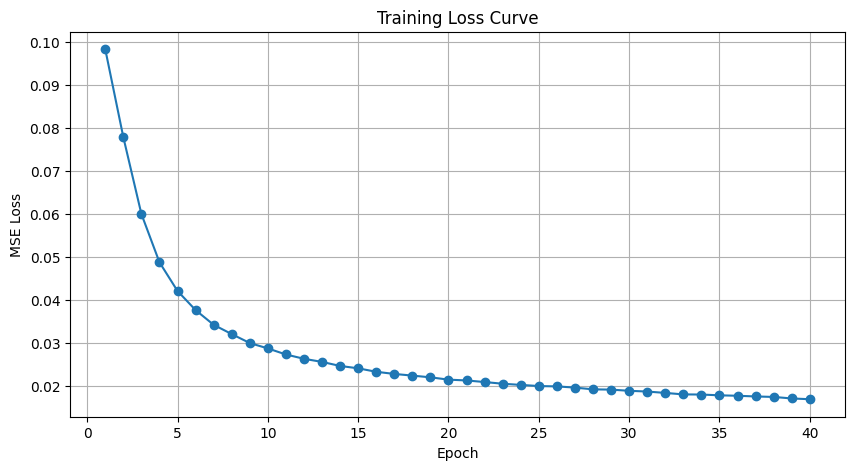

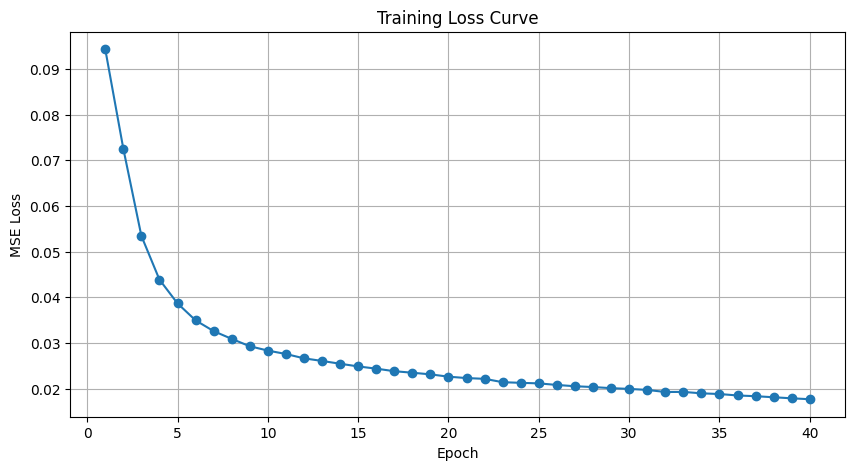

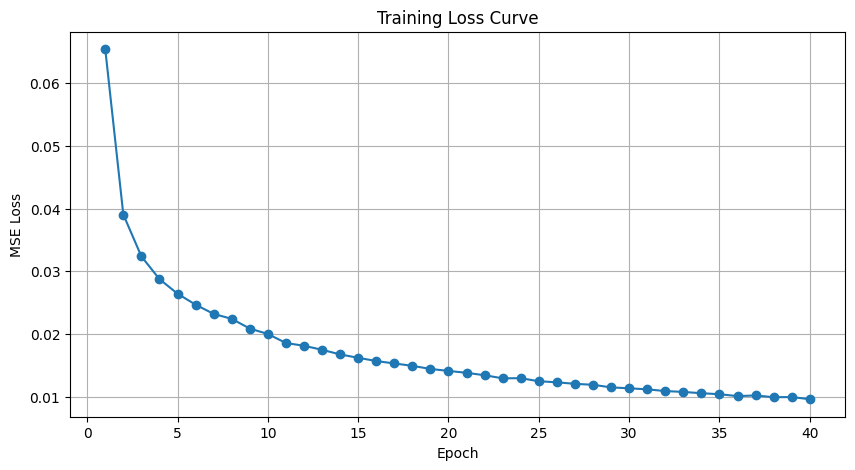

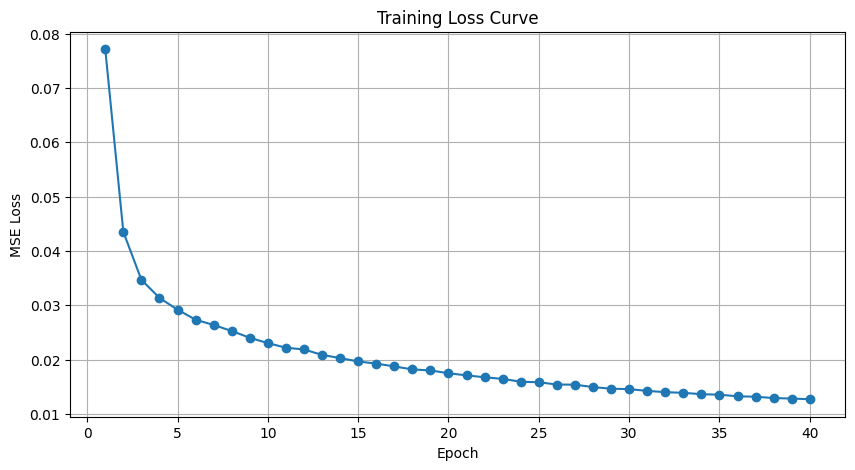

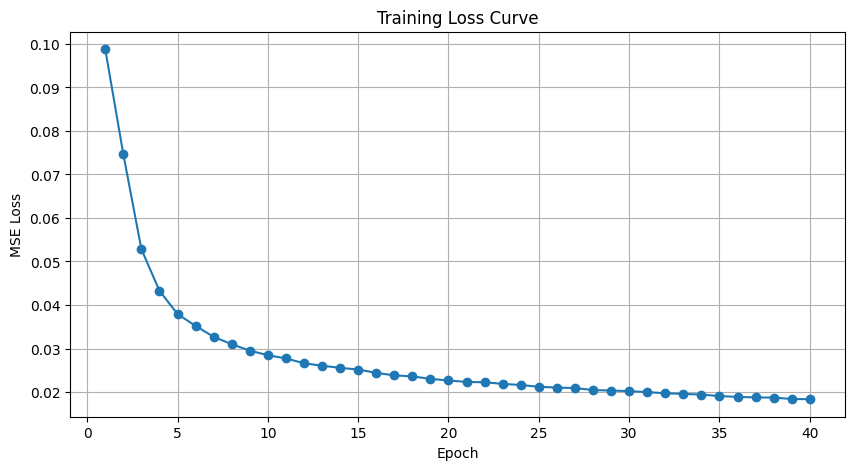

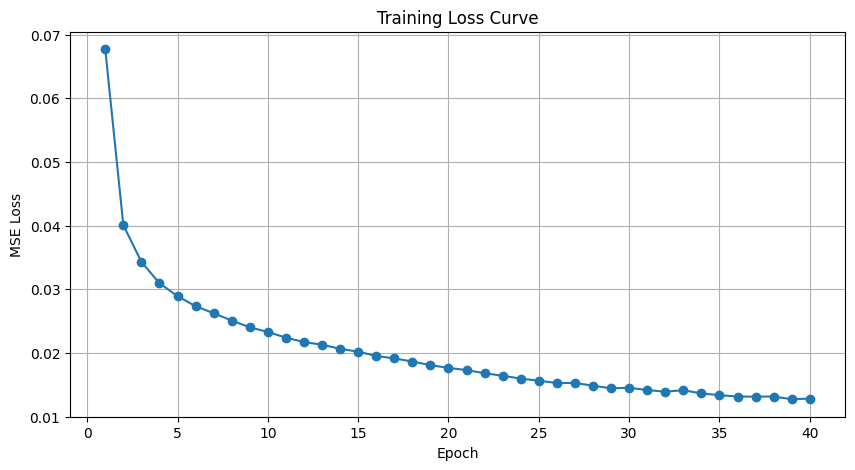

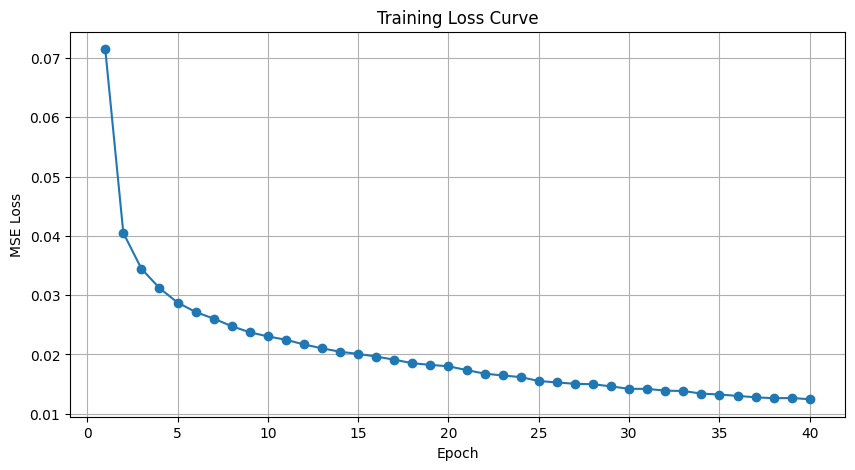

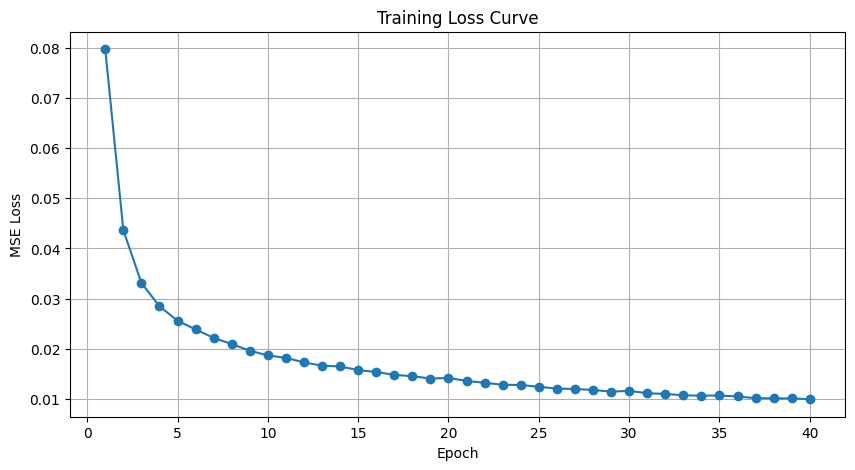

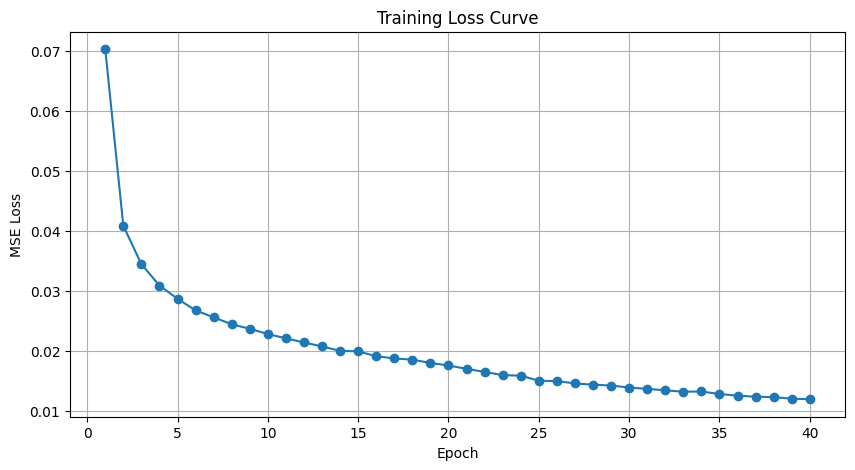

In [ ]:
# Step 8: Create and launch the CAE sweep with artifact logging

# Create the sweep on Weights & Biases
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project="GoTG_Assignment07_AE",
    entity="usf-guardians"
)

print(f"Sweep created with ID: {sweep_id}")

# Launch the sweep agent: run 10 CAE experiments using the improved model
wandb.agent(sweep_id=sweep_id, function=train, count=10)


## 🔍 Sweep Results: Top 3 CAE Models (128x128, Denoising Autoencoder)

We ran 10 Weights & Biases sweep experiments to explore different hyperparameters for our **Improved Convolutional Autoencoder (ImprovedCAE)**, targeting the best reconstruction quality on noisy face images (with Gaussian noise levels up to 0.5).

Below are the **top 3 performing models** based on the **lowest validation MSE (`best_val_mse`)** and their overall generalization on test data.

---

### 🥇 **Top Model: Run `ImprovedCAE_xkv06jqo`**
- **best_val_mse:** 0.00924
- **test_mse:** 0.01391
- **test_r2:** 0.80928
- **train_r2:** 0.87265

**Config:**
- `latent_vector_dim`: **256**
- `dropout_rate`: **0.2**
- `learning_rate`: **0.001**
- `batch_size`: **16**
- `noise_factor`: **0.3**

**🧠 Interpretation:**
This model achieved the **best generalization**, likely due to a balanced setup:
- **Moderate noise (0.3)** lets the model learn meaningful denoising mappings without overwhelming.
- **Latent dim 256** provided sufficient capacity to encode features.
- **Dropout 0.2** helped prevent overfitting, leading to high `train_r2` and `test_r2`.

---

### 🥈 **Second Best: Run `ImprovedCAE_938a4r70`**
- **best_val_mse:** 0.00990
- **test_mse:** 0.01354
- **test_r2:** 0.81447
- **train_r2:** 0.86393

**Config:**
- `latent_vector_dim`: **256**
- `dropout_rate`: **0.2**
- `learning_rate`: **0.0005**
- `batch_size`: **16**
- `noise_factor`: **0.3**

**🧠 Interpretation:**
Almost identical to the top model but with **a lower learning rate**, which may have led to **slightly slower convergence** or underfitting in the early epochs. Still excellent generalization and close in performance.

---

### 🥉 **Third Best: Run `ImprovedCAE_puhhfeb6`**
- **best_val_mse:** 0.00964
- **test_mse:** 0.0143
- **test_r2:** 0.80435
- **train_r2:** 0.86724

**Config:**
- `latent_vector_dim`: **384**
- `dropout_rate`: **0.2**
- `learning_rate`: **0.001**
- `batch_size`: **16**
- `noise_factor`: **0.5**

**🧠 Interpretation:**
This model used **higher noise (0.5)** and a **larger latent size**, allowing it to still reconstruct faces well. However:
- The **larger latent dim** increased model complexity, potentially requiring **more epochs** to converge fully.
- The high noise could have made training harder, but the model still adapted, showing **strong robustness**.

---

## 🔧 Key Takeaways

- ✅ **Latent dim = 256** is a sweet spot: enough expressiveness without overfitting.
- ✅ **Dropout = 0.2** was consistently good across top runs.
- ✅ **Noise = 0.3–0.4** provided realistic corruption while keeping learning stable.
- ⚠️ Larger latent dims like **384** can help but may need longer training or regularization.
- ❌ Higher noise levels (**0.5**) are learnable but slightly reduce generalization unless well-regularized.

---




## 🏁 Conclusion

This project explored the use of **Convolutional Autoencoders (CAEs)** to reconstruct clear facial images from heavily corrupted, low-quality night-time surveillance footage — a creative take on identifying the ice cream thief in a shared household. Our objective was to design and evaluate models that could effectively denoise facial images and retain identity-relevant features.

We implemented and analyzed **four different CAE pipelines**:
1. A simple baseline model with three convolutional layers,
2. Two improved models using Batch Normalization and Dropout to enhance stability and generalization,
3. A final, deeper CAE trained on a larger dataset with 128×128 images and an expanded latent space.

Throughout the project, we carefully examined the effects of:
- **Latent vector dimensionality** (compression vs. representation capacity),
- **Input resolution** (64×64 vs. 128×128),
- **Noise levels** during training (simulating real-world corruption),
- **Model depth** (3-layer vs. 4-layer encoders),
- And regularization techniques like **Dropout** and **Batch Normalization**.

We used **Weights & Biases (W&B)** to run structured hyperparameter sweeps and visualize performance metrics like MSE, MAE, R², and image reconstructions. These experiments helped us compare architectures fairly and uncover what design choices matter most.

### 🔍 Key Takeaways:
- Deeper models with regularization techniques like BatchNorm and Dropout yielded more stable and accurate reconstructions.
- Higher-resolution inputs and larger datasets significantly improved performance under heavy noise.
- A well-balanced latent space (e.g., 128–256 dimensions) preserved key facial features while still enabling strong compression.
- Transposed convolutions, paired with intelligent decoder design, successfully recovered clean images from abstract latent representations.

Overall, our CAE-based approach successfully demonstrated how deep learning models can be applied to real-world problems involving noisy image recovery — with meaningful insights into model design, data preprocessing, and performance optimization.

